Prj05

Consider the Vasicek model $$d r_t = \alpha (b - r_t) dt + \sigma dW_t$$ with the following parameters: $$r_0 = .005, \alpha = 2.11, b = 0.02, \sigma = 0.033.$$

Todo

1. Implement Euler simulation and draw a plot of $\mathbb E[ r_t ]$ on $t\in [0, 10]$.

2. Find explicit form of $\mathbb E [r_t]$ and $\lim_{t\to \infty} \mathbb E [r_t]$.

3. Zero bond price has the formula 
$$P(0, T) = \mathbb E[\exp\{-\int_0^T r(s) ds\}].$$ 
Find the exact value of $P(0,1)$.

4. Run Euler, Milstein, exact simulation on $P(0,1)$ with different stepsizes, and find the covergence rate for each using linear regression. (Hint: one shall approximate integral with finite sum)


In [160]:
import numpy as np
import matplotlib.pyplot as plt

In [161]:
sig = .033
alpha=2.11; b=0.02
Mu = lambda r,t: alpha*(b-r)
Sigma = lambda r,t: sig
r0=0.005

In [162]:
T1=0
T2=10
n=500
#init start time, end time, and the mesh number
t = np.linspace(T1, T2, num = n+1) #init mesh
rh = r0 + np.zeros(n+1) #init state


In [163]:
def SDE_path(Mu, Sigma, r0, T1, T2, n): #para: drift, vol, initial state, start time, end time, and the mesh number 
    t = np.linspace(T1, T2, num = n+1) #init mesh 
    
    rh = r0 + np.zeros(n+1) #init rh
    for i in range(n): #run EM
        rh[i+1] = rh[i] + Mu(rh[i], t[i]) * (t[i+1] - t[i]) + Sigma(rh[i], t[i])* np.sqrt(t[i+1] - t[i])*np.random.normal()
        
    return t, rh

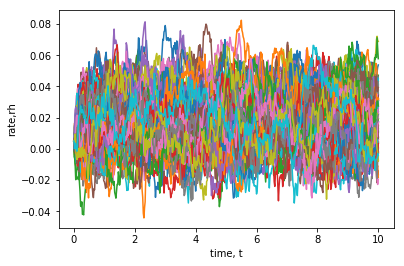

In [164]:
for i in range(100): 
    [t, rh] = SDE_path(Mu, Sigma, r0, T1, T2, n); 
    plt.plot(t,rh);
    plt.xlabel("time, t")
    plt.ylabel("rate,rh")

In [165]:
p=np.zeros(100)
p[i]=rh[-1]#p[i]=PutPay(r,T1-T0,K,xh[-1]),sum=sum+xh[-1]

In [166]:
print('The E[rt]=',p.mean())

The E[rt]= -4.014660117015893e-05


Firstly, the model are shown:
$$ dr_t=a(b-r_t)dt+\sigma dW_t $$
From Ito's formula,we can have:
$$r_t=e^{-at}[r_0+\int_0^tabe^{au}du+\sigma \int_0^te^{au}dW_u]   $$
$$r_t= \mu_t +\sigma \int_0^t e^{a(u-t)}dW_u      (1) $$

The integral of the vasicek model is :
$$ r_t= r_0+\int_0^t a(b-r_u)du+\sigma dW_u         (2)         $$
Compares the two equations (1) (2) :
$$   \mu_t=\mathbb E[r_t]=r_0+\int_0^ta(b-\mathbb E[r_u])du      $$
Through the caculation, the expection of short rate is :
$$ \mathbb E[r_t]=e^{-at}[r_0+b(e^{at}-1)]      $$
If the stochastic term is included, the explicit solution can be found:
$$ r_t=e^{-at}[r_0+b(e^{at}-1)] + \sigma \int_0^t dW_t    $$
Therefore, $$ lim_{t \rightarrow \infty} \mathbb E[r_t] = b $$

In [167]:
B=1.0/alpha*(1-1.0/np.exp(alpha))
A=np.exp((b-sig**2/2.0/alpha**2)*(B-1)-sig**2/4.0/alpha*B**2)

P=A*np.exp(-1*B*r0)
B
A
print('The bond price P(0,1)=',P)

The bond price P(0,1)= 0.9863895803459704


In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class SDE:
    
    """
    Initialize
    """
    def __init__(self, Mu, Sigma, InitState):
        self.Mu = Mu
        self.Sigma = Sigma
        self.InitState = InitState
        
        self.MuP = lambda x, t: 0 #first order derivative of Mu
                                #used for Milstein
        
    """
    Euler method
    """
    def Euler(self, T, N):
        x0 = self.InitState
        Mu = self.Mu
        Sigma = self.Sigma       
        t = np.linspace(0, T, N+1)
        DeltaT = T/N
        
        Wh = np.zeros(N+1) #init BM
        Xh = x0 + np.zeros(N+1) #init Xh
        
        for i in range(N): #run EM            
            DeltaW = np.sqrt(t[i+1] - t[i]) * np.random.normal()
            Wh[i+1] = Wh[i] + DeltaW
            Xh[i+1] = Xh[i] + \
                Mu(Xh[i], t[i]) * DeltaT + \
                Sigma(Xh[i], t[i])* DeltaW
            
        return t, Xh, Wh


    """
    Milstein method
    """
    
    def Milstein(self, T, N):
        x0 = self.InitState
        Mu = self.Mu
        MuP = self.MuP
        
        Sigma = self.Sigma
        t = np.linspace(0, T, N+1)
        DeltaT = T/N
        
        Wh = np.zeros(N+1) #init BM
        Xh = x0 + np.zeros(N+1) #init Xh
        
        for i in range(N):
            DeltaW = np.sqrt(t[i+1] - t[i]) * np.random.normal()
            Wh[i+1] = Wh[i] + DeltaW
            Xh[i+1] = Xh[i] + \
                Mu(Xh[i], t[i]) * DeltaT + \
                Sigma(Xh[i], t[i])* DeltaW #Euler
            Xh[i+1] = Xh[i+1] + \
                0.5 * Mu(Xh[i], t[i]) * MuP(Xh[i], t[i]) \
                * (DeltaW**2 - DeltaT)
                
        return t, Xh, Wh
         


In [169]:
    """
    Exact simulation
    """
def Exact(self,a,b,T,sigma,N):
        
        x0 = self.InitState      
        t = np.linspace(0, T, N+1)
        Xh = x0 + np.zeros(N+1)
        
        for i in range(N):
            Xh[i+1]=x0*np.exp(-1*a*t[i+1])+\
            b-b*np.exp(-1*a*t[i+1])+sigma*np.random.normal()       
        return Xh

    """
    Explict solution
    """
    def Explicit(self,a,b, T, Wt):
        x0 = self.InitState
        xh=x0*np.exp(-1*a*T)+b-b*np.exp(-1*a*T)+Wt
            
        return xh
    
    def Bond_Exact(self,a,b,sigma):
        x0 = self.InitState
        B=1.0/a*(1-1.0/np.exp(a))
        A=np.exp((b-sigma**2/2.0/a**2)*(B-1)-sigma**2/4.0/a*B**2)
        P=A*np.exp(-1*B*x0)
        
        return P

In [170]:
if __name__ == '__main__':
    
    #OU process
    a=2.11
    b=0.02
    mu = lambda x, t: a*(b-x)
    sigma = lambda x, t: 0.033
    sig=0.033
    x0 = 0.005
   
    iSDE = SDE(mu, sigma, x0)

    ArrLog2Steps = np.arange(8)
    NumMinLog2Steps = 4 

    ArrErr_Euler = np.zeros(ArrLog2Steps.size)
    ArrErr_Milstein = np.zeros(ArrLog2Steps.size)
    ArrErr_Exact = np.zeros(ArrLog2Steps.size)
    T = 1.
    NumSimu = 200
    '''
    Exact price of zero-coupon bond
    '''
    P=iSDE.Bond_Exact(a,b,sig)
    
    for n in ArrLog2Steps:
        NumMesh = np.power(2, n + NumMinLog2Steps)
        errsum_Euler = 0
        errsum_Milstein = 0
        errsum_Exact = 0
        
        deltaT=T/NumMesh
        
        for i in range(NumSimu):
            
            '''
            Euler simulation
            '''            
            [t, Xh, Wh] = iSDE.Euler(T, NumMesh)
            XhT = Xh[-1]
            #XT = iSDE.Explicit(a,b,T,Wh[-1])
            PhT=np.exp(-1.0*deltaT*np.sum(Xh))
            errsum_Euler = errsum_Euler + np.abs(PhT - P)
            #plt.plot(t,Xh)
            '''
            Milstein simulation
            '''            
            [t, Xh, Wh] = iSDE.Milstein(T, NumMesh)
            XhT = Xh[-1]
            #XT = iSDE.Explicit(a,b,T,Wh[-1])
            PhT=np.exp(-1.0*deltaT*np.sum(Xh))         
            errsum_Milstein = errsum_Milstein + np.abs(PhT - P)
            '''
            Exact simulation
            '''            
            
            Xh= iSDE.Exact(a,b,T,sig,NumMesh)
            #XhT = Xh[-1]
            #XT= iSDE.Explicit(a,b,T,Wh[-1])
            
            
            PhT=np.exp(-1.0*deltaT*np.sum(Xh))
            errsum_Exact = errsum_Exact + np.abs(PhT - P)

        ArrErr_Euler[n] = errsum_Euler/NumSimu
        ArrErr_Milstein[n] = errsum_Milstein/NumSimu
        ArrErr_Exact[n] = errsum_Exact/NumSimu        

    
    x_coordinate = ArrLog2Steps+NumMinLog2Steps
    y_coordinate_Euler = np.log(ArrErr_Euler)
    y_coordinate_Milstein = np.log(ArrErr_Milstein)
    y_coordinate_Exact = np.log(ArrErr_Exact)    
    plt.plot(x_coordinate, y_coordinate_Euler,label='Euler')
    plt.plot(x_coordinate, y_coordinate_Milstein,label='Milstein')    
    plt.plot(x_coordinate, y_coordinate_Exact,label='Exact simulation')
    plt.legend()   
    
    lg1 = stats.linregress(x_coordinate,y_coordinate_Euler)
    lg2 = stats.linregress(x_coordinate,y_coordinate_Milstein)    
    lg3 = stats.linregress(x_coordinate,y_coordinate_Exact)
    rate1 = -lg1[0]
    rate2=-lg2[0]
    rate3=-lg3[0]
    print('Euler method  covergence rate is '+ str(rate1))
    print('Milstein method  covergence rate is '+ str(rate2))        
    print('Exact simulation  covergence rate is '+ str(rate3))

AttributeError: 'SDE' object has no attribute 'Bond_Exact'